In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.tabular import *

In [3]:
torch.cuda.set_device(0)

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [6]:
path = Path('/home/jupyter/.fastai/data/rossmann/')
train_df = pd.read_pickle(path/'train_clean')

In [7]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [8]:
n = len(train_df); n

844338

### Experimenting with a sample

In [9]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [10]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
1295,183,4,NaN,9670.0,59,6066
1427,316,4,NaN,9000.0,73,10450
1453,342,4,"Jan,Apr,Jul,Oct",15770.0,59,13146
1684,573,4,"Jan,Apr,Jul,Oct",1190.0,59,4298
2021,911,4,NaN,16490.0,86,9869


In [11]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
421560,765,2,"Jan,Apr,Jul,Oct",25430.0,55,8936
422685,776,1,"Jan,Apr,Jul,Oct",700.0,54,8602
422790,881,1,"Feb,May,Aug,Nov",180.0,54,9142
423254,200,6,NaN,1650.0,48,6706
423338,284,6,"Jan,Apr,Jul,Oct",1290.0,70,5559


In [12]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [13]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
421560,765.0,2,"Jan,Apr,Jul,Oct",25430.0,55,8936
422685,776.0,1,"Jan,Apr,Jul,Oct",700.0,54,8602
422790,881.0,1,"Feb,May,Aug,Nov",180.0,54,9142
423254,200.0,6,NaN,1650.0,48,6706
423338,NaN,6,"Jan,Apr,Jul,Oct",1290.0,70,5559


In [14]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [15]:
small_train_df['PromoInterval'].cat.codes[:5]

1295   -1
1427   -1
1453    1
1684    1
2021   -1
dtype: int8

In [16]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [17]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
190483,879,4,"Feb,May,Aug,Nov",2260.0,82,4510,True
195774,879,5,"Feb,May,Aug,Nov",2260.0,96,4204,True
199093,291,6,NaN,2260.0,86,8031,True
203179,622,6,NaN,2260.0,83,4596,True


### Preparing full data set

In [18]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [19]:
len(train_df),len(test_df)

(844338, 41088)

In [20]:
procs=[FillMissing, Categorify, Normalize]

In [21]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [22]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [23]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [24]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [25]:
valid_idx = range(cut)

In [26]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [27]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

In [28]:
doc(FloatList)

class FloatList [source] FloatList ( items : Iterator [ T_co ], log : bool = False , kwargs ) :: ItemList 
 
 ItemList suitable for storing the floats in items for regression. Will add a log if True 
 Show in docs

## Model

In [29]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [30]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [32]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [33]:
len(data.train_ds.cont_names)

16

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


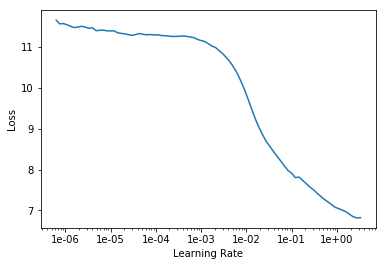

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe
1,0.024271,0.019602,0.131676
2,0.019457,0.021848,0.129144
3,0.016207,0.014952,0.120604
4,0.014332,0.011759,0.107531
5,0.011605,0.011560,0.105060


In [37]:
learn.save('1')

In [38]:
from my_python_tricks import *
notify_me()

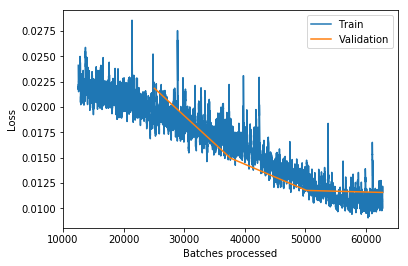

In [39]:
learn.recorder.plot_losses(last=-1)

In [40]:
learn.load('1');

In [41]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.012763,0.016335,0.119015
2,0.013287,0.012293,0.108581
3,0.010786,0.014185,0.116849
4,0.010310,0.013617,0.116749
5,0.008909,0.013946,0.118290


In [42]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011189,0.014021,0.122102
2,0.010751,0.021548,0.127573
3,0.010650,0.019551,0.139369
4,0.009634,0.021288,0.134890
5,0.009103,0.020600,0.138199


(10th place in the competition was 0.108)

## fin

In [43]:
from my_python_tricks import *
notify_me()